In [1]:
import rasterio
from rasterstats import zonal_stats
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterstats
import pandas as pd
import glob
from tqdm import tqdm
import rasterio.mask
from dotenv import load_dotenv
import os
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

# Set the path to the raster files
load_dotenv()
file_path = os.getenv("path")

In [36]:
ALBERS_CONICAL_EQUAL_AREA =  'PROJCS["Albers_Conic_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",44.75],PARAMETER["standard_parallel_2",55.75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

Crop Data for Ontario

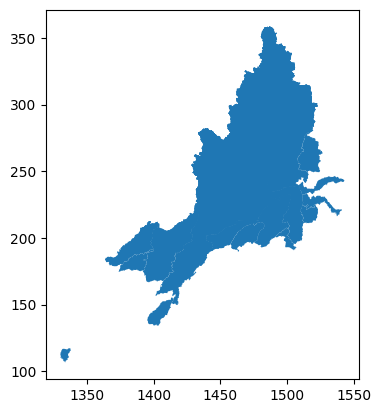

In [13]:
zone_path = os.path.join(file_path, "LEB_description", "sub-basin _ArcGIS","LEB_ONsubbasins_30Sept2021.shp")
zones = gpd.read_file(zone_path)
zones.plot()
plt.show()

In [14]:
print(zones.crs)

# change the crs:
shapefile = zones.to_crs(
    'PROJCS["Albers_Conic_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",44.75],PARAMETER["standard_parallel_2",55.75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

PROJCS["Lambert_Conformal_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["kilometer",1000],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [12]:
rf_path = os.path.join(
    file_path, "raw_data", "crops_data", "ON_crop_data", "2011", "on_beans2011.tif"
)
# read the crop raster
rf = rasterio.open(rf_path, mode='r')
# show(rf)

print(f'meta_data {r.meta}')

meta_data {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 7721, 'height': 8987, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Albers_Conic_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",44.75],PARAMETER["standard_parallel_2",55.75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 1073479.7600842193,
       0.0, -30.0, 602198.9728436815)}


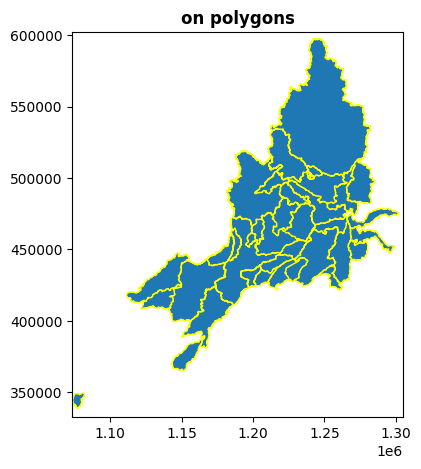

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
show(rf, ax=ax, title="on polygons")
shapefile.plot(ax=ax, facecolor=None, edgecolor="yellow")

plt.show()

Batch Processing for Ontario Crop Data

In [ ]:
# ontario shapefile:
ca_zone_path = os.path.join(file_path, "LEB_description", "sub-basin _ArcGIS", "LEB_ONsubbasins_30Sept2021.shp")
on_polygons = gpd.read_file(ca_zone_path)

# the counts to be use while computing the percentage
count_reference = pd.read_csv(os.path.join(file_path, "raw_data", "crops_data", "ON_counts.csv"))
count_reference["ncells"]
StationNames = list(count_reference["station"])

# change crs to match the crs of the crop maps:
shapefile = on_polygons.to_crs('PROJCS["Albers_Conic_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",44.75],PARAMETER["standard_parallel_2",55.75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

# the main folder
directory = os.path.join(file_path, "raw_data", "crops_data", "ON_crop_data/*")

listofdirectories = glob.glob(directory)
listofdirectories.sort()

for folder in tqdm(listofdirectories):
    listofcropmaps = glob.glob(folder + "/*.tif")
    listofcropmaps.sort()

    # list of all crops dictionary:
    singlecropdict = {}

    for raster in tqdm(listofcropmaps):
        rastefile = rasterio.open(raster, mode="r")
        affine = rastefile.transform
        crop_array = rastefile.read(1)

        # calculating zonal statistics:
        sum_rf = rasterstats.zonal_stats(
            shapefile,
            crop_array,
            affine=affine,
            stats=["count"],
            geojson_out=True,
            nodata=0,
        )

        # extracting cropmaps sums data from the list:
        sum_cropmap = []
        i = 0

        while i < len(sum_rf):
            sum_cropmap.append(sum_rf[i]["properties"])
            i = i + 1

        # transforming information into a dataframe:
        sorted_data = sorted(sum_cropmap, key=lambda x: x["Station"])
        df_sum_cropmap = pd.DataFrame(sorted_data)

        # collecting all the sums into one big list
        cropName = raster.split("/")[-1].split(".")[0]
        cropsumvalues = list(df_sum_cropmap["count"])
        singlecrop = {cropName: cropsumvalues}

        singlecropdict.update(singlecrop)

        # calculate the percentage count of each crop:
        df_singlecrop = pd.DataFrame(singlecropdict)

        df_singlecrop.insert(0, "ncells", count_reference["ncells"])

        new_df_singlecrop = df_singlecrop.set_index("ncells")

        percent_singlecrop = new_df_singlecrop.apply(
            lambda x: x * (100 / new_df_singlecrop.index)
        )

        percent_singlecrop.insert(0, "station", StationNames)

        # saving to csv :
        # pathout =
        # percent_singlecrop.to_csv(
        #     pathout + "on_" + folder.split("/")[-1] + ".csv", index=True
        # )

Crop Data for LEB portion from the USA

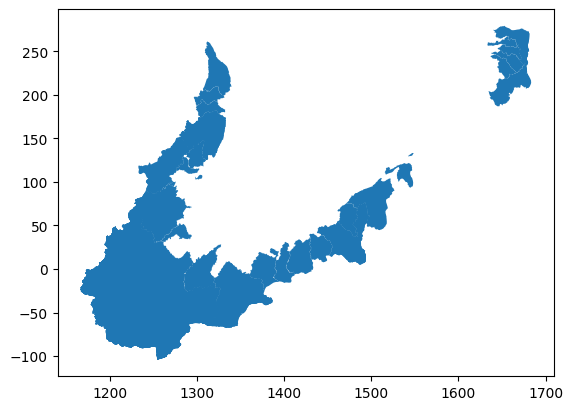

In [20]:
# LEB_USAsubbasins_30Sept2021.shp
us_zone_path = os.path.join(
    file_path, "LEB_description", "sub-basin _ArcGIS", "LEB_USAsubbasins_30Sept2021.shp"
)
us_zones = gpd.read_file(us_zone_path)
us_zones.plot()
plt.show()

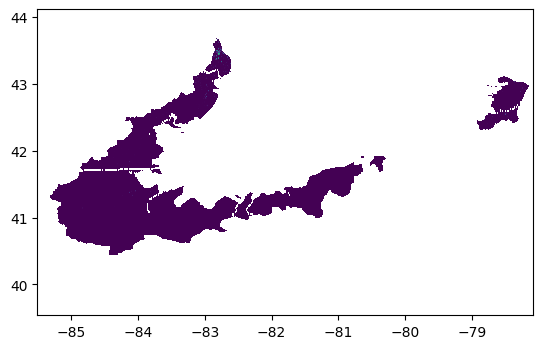

<Axes: >

In [24]:
us_rf_path = os.path.join(
    file_path, "raw_data", "crops_data", "US_crop_data", "2011", "us_beans2011.tif"
)
# read the crop raster
us_rf = rasterio.open(us_rf_path, mode="r")
show(us_rf)

In [ ]:
# us shapefile:
us_polygons = gpd.read_file(us_zone_path)

# the counts to be use while computing the percentage
us_count_reference = pd.read_csv(os.path.join(file_path, "raw_data", "crops_data", "US_counts.csv"))

us_count_reference["ncells"]
StationNames = list(us_count_reference["station"])

# the main folder
directory = os.path.join(file_path, "raw_data", "crops_data", "US_crop_data/*")

listofdirectories = glob.glob(directory)
listofdirectories.sort()

for folder in tqdm(listofdirectories):
    listofcropmaps = glob.glob(folder + "/*.tif")
    listofcropmaps.sort()

    # list of all crops dictionary:
    singlecropdict = {}

    for raster in tqdm(listofcropmaps):
        rasterfile = rasterio.open(raster, mode="r")
        cropmap_array = rasterfile.read(1)
        affine = rasterfile.transform

        # First the shapefile:
        default_crs = "EPSG:5070"
        if us_polygons.crs is None:
            us_polygons = us_polygons.set_crs(default_crs)

        us_polygons = us_polygons.to_crs(rasterfile.crs)

        sum_rf = zonal_stats(
            us_polygons,
            cropmap_array,
            affine=affine,
            stats=["count", "sum"],
            geojson_out=True,
            nodata=0,
        )

        # extracting cropmaps sums data from the list:
        sum_cropmap = []
        i = 0

        while i < len(sum_rf):
            sum_cropmap.append(sum_rf[i]["properties"])
            i = i + 1

        # transforming information into a dataframe:
        sorted_data = sorted(sum_cropmap, key=lambda x: x["GAGE_ID"])
        df_sum_cropmap = pd.DataFrame(sorted_data)

        # collecting all the sums into one big list
        cropName = raster.split("/")[-1].split(".")[0]
        cropsumvalues = list(df_sum_cropmap["count"])
        singlecrop = {cropName: cropsumvalues}

        singlecropdict.update(singlecrop)

        # calculate the percentage count of each crop:
        df_singlecrop = pd.DataFrame(singlecropdict)

        df_singlecrop.insert(0, "ncells", us_count_reference["ncells"])

        new_df_singlecrop = df_singlecrop.set_index("ncells")

        percent_singlecrop = new_df_singlecrop.apply(
            lambda x: x * (100 / new_df_singlecrop.index)
        )

        percent_singlecrop.insert(0, "station", StationNames)
        # saving to csv :
        # pathout =

        # percent_singlecrop.to_csv(
        #     pathout + "us_" + folder.split("/")[-1] + ".csv", index=True
        # )

Plotting leb-subbasins

<Axes: >

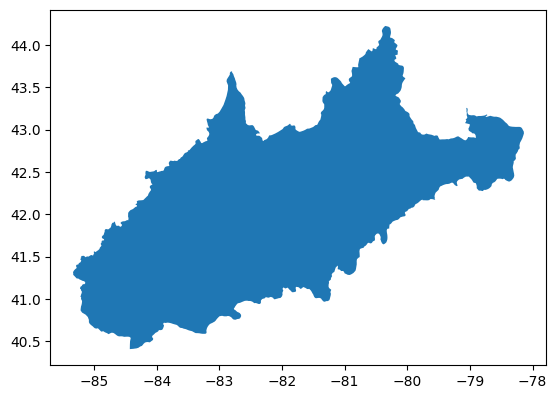

In [40]:
leb_boundary_path = os.path.join(file_path, "LEB_description", "sub-basin _ArcGIS", "LakeErieBasinBoundaries.shp")
leb_boundary =gpd.read_file(leb_boundary_path)
leb_boundary.to_crs(ALBERS_CONICAL_EQUAL_AREA)

leb_boundary.plot()

In [2]:
basin_path = os.path.join(file_path, "raw_data", "basins.csv")
basin_df = pd.read_csv(basin_path)

### plot crop binaries over 10 years

100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


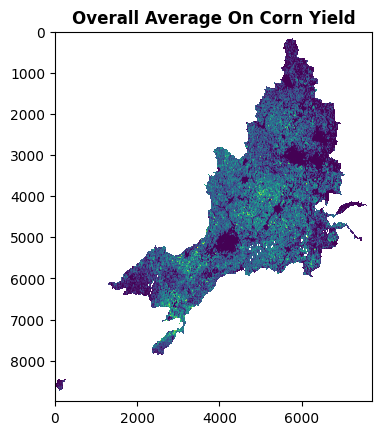

100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


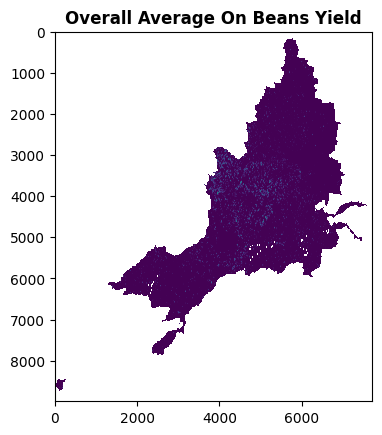

100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


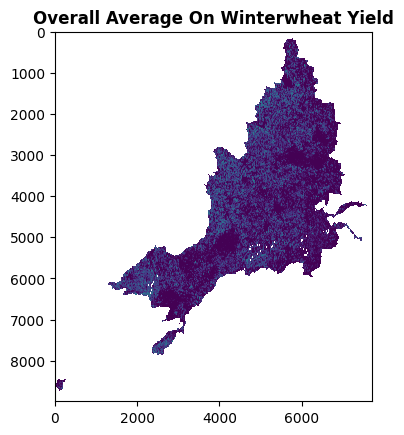

In [1]:
# ontario 
import os
import glob
import rasterio
from rasterio.plot import show
import numpy as np
from tqdm import tqdm

def aggregate_crop_data(file_path, crop_name, country):
    directory = os.path.join(file_path, "raw_data", "crops_data", f"{country}_crop_data/*")

    on_crops_listofdirectories = glob.glob(directory)
    on_crops_listofdirectories.sort()

    all_masked_arrays = []

    for folder in tqdm(on_crops_listofdirectories):
        listofcropmaps = glob.glob(folder + "/*.tif")
        listofcropmaps.sort()
        
        crop_maps = [cropmap for cropmap in listofcropmaps if os.path.basename(cropmap).startswith(crop_name)]

        # mask the no-data values for each crop map
        for cropmap in crop_maps:
            with rasterio.open(cropmap, mode='r') as src:
                data = src.read(1)
                masked_data = np.ma.masked_equal(data, 255.0)
                all_masked_arrays.append(masked_data)

    # compute the overall average, ignoring no-data values
    if all_masked_arrays:
        overall_average_crop = np.ma.mean(np.ma.stack(all_masked_arrays), axis=0)

        # display the final averaged raster
        show(overall_average_crop, title=f"Overall Average {crop_name.replace('_', ' ').title()} Yield")

# test
file_path = os.getenv("path")
corn = "on_corn"
aggregate_crop_data(file_path, corn, "ON")

beans = "on_beans"
aggregate_crop_data(file_path, beans, "ON")

winter_wheat = "on_winterwheat"
aggregate_crop_data(file_path, winter_wheat, "ON")

100%|██████████| 9/9 [00:00<00:00, 6233.28it/s]


current year crop map: us_soybeans2011.tif
current year crop map: us_soybeans2013.tif
current year crop map: us_soybeans2014.tif
current year crop map: us_soybeans2015.tif
current year crop map: us_soybeans2016.tif
current year crop map: us_soybeans2018.tif
current year crop map: us_soybeans2019.tif
current year crop map: us_soybeans2020.tif


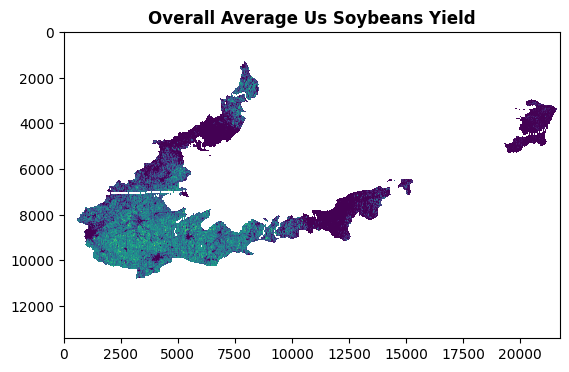

In [10]:
import os
import glob
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def aggregate_crop_data(file_path, crop_name, country):
    def get_first_cropmap_meta(crop_maps):
        with rasterio.open(crop_maps[0], mode='r') as src:
            first_cropmap_meta = src.meta.copy()
            first_cropmap_transform = src.transform
            first_cropmap_crs = src.crs
            first_cropmap_height = src.height
            first_cropmap_width = src.width
            first_cropmap_nodata = first_cropmap_meta.get('nodata', None)
            first_cropmap_meta_count = 1  

        return {
            "meta": first_cropmap_meta,
            "transform": first_cropmap_transform,
            "crs": first_cropmap_crs,
            "height": first_cropmap_height,
            "width": first_cropmap_width,
            "nodata": first_cropmap_nodata,
            "count": first_cropmap_meta_count
        }

    directory = os.path.join(file_path, "raw_data", "crops_data", f"{country}_crop_data/*")

    on_crops_listofdirectories = glob.glob(directory)
    on_crops_listofdirectories.sort()

    all_masked_arrays = []
    crop_maps = []

    for folder in tqdm(on_crops_listofdirectories):
        listofcropmaps = glob.glob(folder + "/*.tif")
        listofcropmaps.sort()

        for cropmap in listofcropmaps:
            if os.path.basename(cropmap).startswith(crop_name):
                crop_maps.append(cropmap)
    
    # Get metadata from the first crop map
    first_cropmap_meta = get_first_cropmap_meta(crop_maps)

    for cropmap in crop_maps:
        print(f'current year crop map: {cropmap.split("/")[-1]}')
        with rasterio.open(cropmap, mode='r') as src:
            # print(f'meta height and width: {src.height}, {src.width}')
            # print('------------------------')

            data = src.read(1)
            cropmap_height = src.height
            cropmap_width = src.width

            if cropmap_height != first_cropmap_meta["height"] or cropmap_width != first_cropmap_meta["width"]:
                # print(f"Resampling {cropmap} to match the first crop map dimensions.")
                dest = np.zeros((first_cropmap_meta['height'], first_cropmap_meta['width']), dtype=data.dtype)
                
                reproject(
                    source=rasterio.band(src, 1),
                    destination=dest,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=first_cropmap_meta["transform"],
                    dst_crs=first_cropmap_meta["crs"],
                    resampling=Resampling.nearest
                )
            else:
                dest = data

            # Mask no-data values
            masked_data = np.ma.masked_equal(dest, first_cropmap_meta["nodata"])
            all_masked_arrays.append(masked_data)

    # Compute the overall average, ignoring no-data values
    if all_masked_arrays:
        overall_average_crop = np.ma.mean(np.ma.stack(all_masked_arrays), axis=0)

        # Display the final averaged raster
        cmap = plt.cm.viridis
        cmap.set_bad(color='white')
        show(overall_average_crop, title=f"Overall Average {crop_name.replace('_', ' ').title()} Yield")

# Example usage
file_path = os.getenv("path")
corn = "us_soybeans"
aggregate_crop_data(file_path, corn, "US")

# beans = "on_beans"
# aggregate_crop_data(file_path, beans, "US")

# winter_wheat = "on_winterwheat"
# aggregate_crop_data(file_path, winter_wheat, "US")

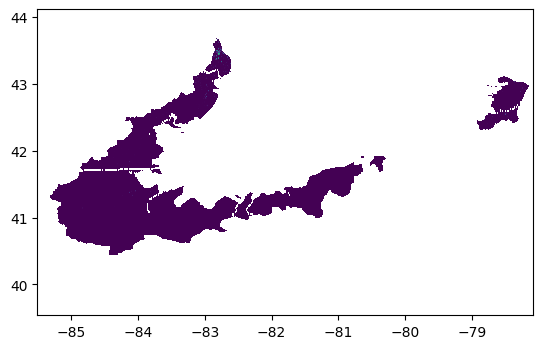

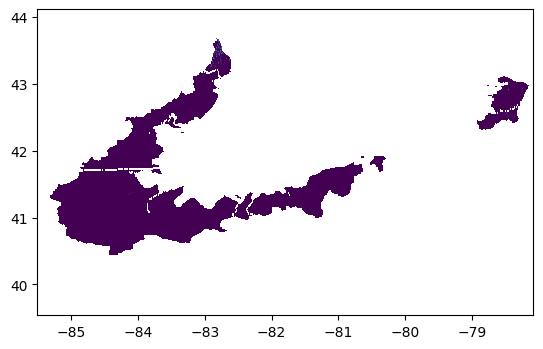

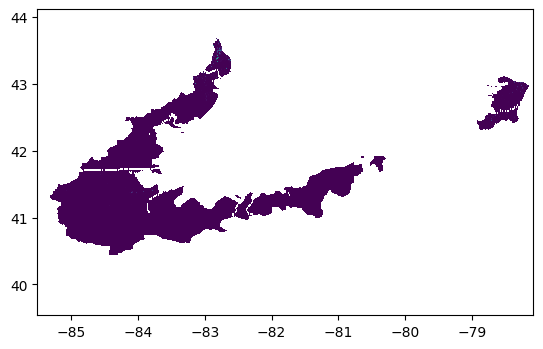

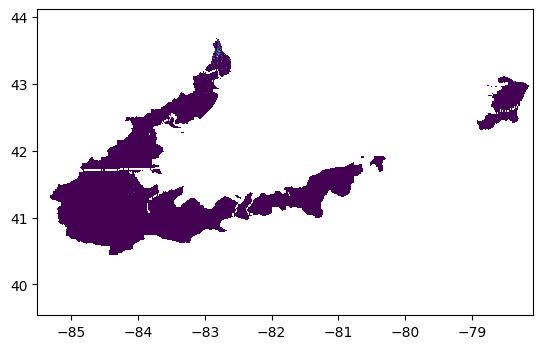

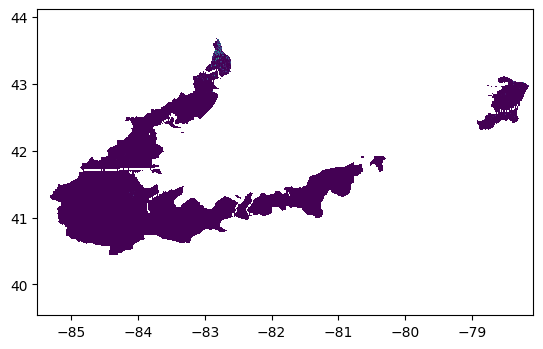

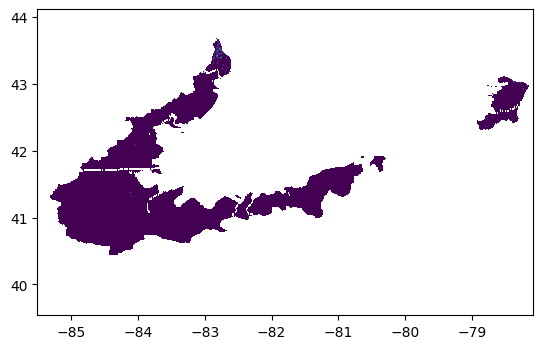

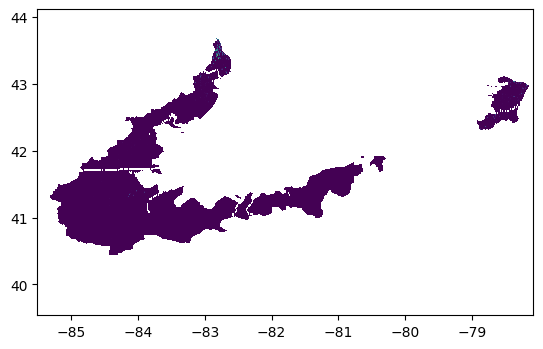

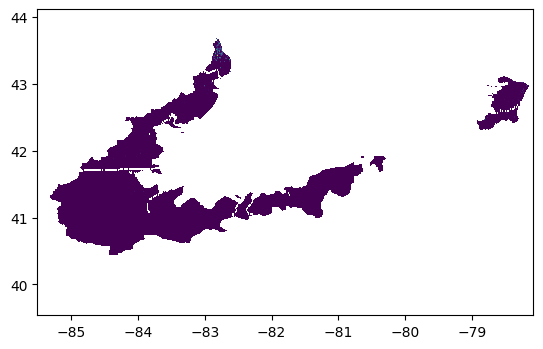

In [13]:
for i in range(1, 10):
    if i == 7:
        continue
    rf_path = os.path.join(
        file_path, "raw_data", "crops_data", "US_crop_data", f"201{i}", f"us_beans201{i}.tif"
    )
    # read the crop raster
    rf = rasterio.open(rf_path, mode='r')
    show(rf)